## Preparação dos dados EOG

Neste notebook está incluído os seguintes passos:
- Realização do carregamento do *dataset*;
- Aplicação dos filtros temporais (~ 5-50 Hz) - deixado como **tarefa**;
- Segmentação de dados nos domínios do tempo e da frequência em janelas deslizantes com sobreposição.

In [44]:
import math
import numpy as np
from scipy import signal
from scipy.signal import stft

### Load

In [45]:
# Carregamento dos datasets

data1 = np.load("../../datasets/eog/Gabi.npy")
data2 = np.load("../../datasets/eog/Jesse.npy")

data1.shape, data2.shape

((28, 1000, 4), (28, 1000, 4))

In [46]:
# Correção do número de eletrodos e unificação

# os dois primeiros eletrodos são funcionais
data1 = data1[:,:,:2]
data2 = data2[:,:,:2]

data = np.array([data1, data2])

# colocando os dados da dimensão final
data = data.transpose(0, 1, 3, 2)

# (subjects, instances, eletrodes, values)
data.shape

(2, 28, 2, 1000)

### Processing

In [47]:
# funcões para aplicação dos filtros temporais

def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

*Tarefa 1*: Realizem a aplicação dos filtros para toda a base.

In [48]:
# aplicação dos filtros
data_filtered = butter_notch(data, 60)
data_filtered = butter_bandpass(data_filtered, 5, 50)
data_filtered.shape

(2, 28, 2, 1000)

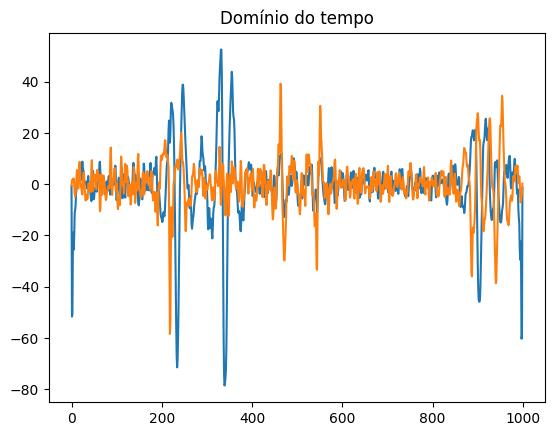

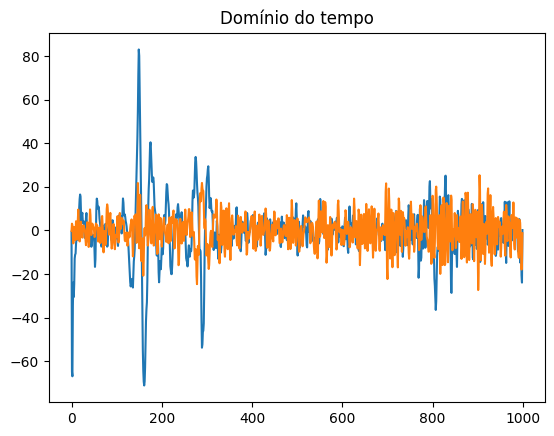

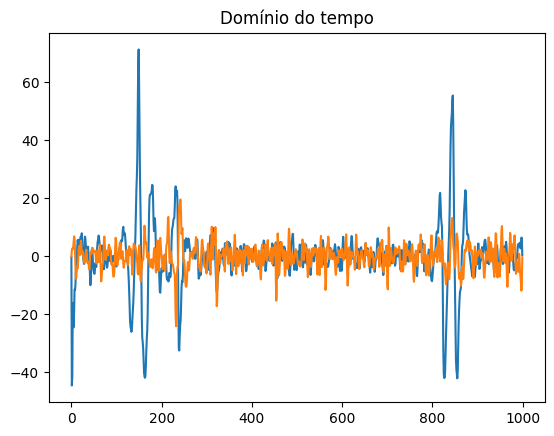

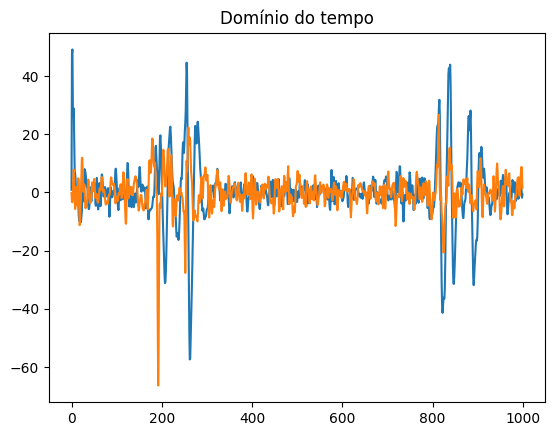

In [49]:
import matplotlib.pyplot as plt
for i in [1, 6, 15, 26]:
    for j in range(data_filtered.shape[2]):
        plt.plot(data_filtered[0, i, j, :])
    plt.title('Domínio do tempo')
    plt.show()

#### Segmentação dos dados

As características normalmente são extraídas sobre pequenos segmentos de tamanho fixo dos dados, não no dado como um todo. Estes pequenos segmentos são chamados de janelas. A técnica de separar os dados em janelas, recebe o nome de janela deslizante (*sliding window*) e é uma forma de segmentação de dados. Uma boa prática, é definir um passo para essa janela de forma que haja uma sopreposição de dados, para que informações da lacuna de uma janela e outra não sejam perdidas. Na imagem a seguir podemos observar um sinal EOG.

Algumas características de EMG trabalham com o dado no domínio da frequência. Quando tais características são aplicadas, é necessário tranformar o dado para o domínio da frequência, utilizando o método de transformação de domínio `STFT`, do inglês *Short-time Fourier transform* (Transformada de Fourier de curto termo). 

Os trechos de código a seguir dividem o dadom em segmentos, tanto no domínio do tempo quanto no domínio da frequência.

In [50]:
data_filtered = data_filtered[:, :, :, 200:400]
print('Shape inicial:', data_filtered.shape)

step = 18
segment = 64

n_win = int((data_filtered.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data_filtered[:,:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 3, 0, 4)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data_filtered, fs=200, nperseg=segment, noverlap=math.ceil(segment/2))
chunks_freq = np.swapaxes(chunks_freq, 3, 4)

# info

# print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (participantes, ensaios, eletrodos, janelas, valores)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (participantes, ensaios, eletrodos, janelas, valores)')

Shape inicial: (2, 28, 2, 200)
Dominio do tempo: (2, 28, 2, 8, 64) - (participantes, ensaios, eletrodos, janelas, valores)
Dominio da frequência:  (2, 28, 2, 8, 33) - (participantes, ensaios, eletrodos, janelas, valores)


*Tarefa 2*: separar os participantes e armazenar os dados em disco para a execução das próximas tarefas.

In [51]:
np.save("processed/segmented_data_t.npy", chunks_time)
np.save("processed/segmented_data_f.npy", chunks_freq)